# Project 3: BD Analytics Clustering Project

#### Kristjan Lõhmus

University of Tartu

## 1. Preliminaries

Got the 'DBLP-Citation-network V10' dataset from https://www.aminer.org/citation. The file was unzipped into a folder called dblp.

In [1]:
from pyspark.sql import SparkSession
from pyspark import StorageLevel
from pyspark.sql.types import StructType, StructField, StringType, ArrayType, IntegerType

## 2. Read the dataset using Spark

There are some mistakes in the inferred schema. (such as year being long type). So we'll define our own schema structure.

In [2]:
spark = SparkSession.builder.config("spark.executor.cores", "4").config("spark.driver.memory", "8g").getOrCreate()
spark.catalog.clearCache()
schema = StructType([
    StructField("abstract", StringType(), True),
    StructField("authors", ArrayType(StringType()), True),
    StructField("id", StringType(), True),
    StructField("n_citation", IntegerType(), True),
    StructField("references", ArrayType(StringType()), True),
    StructField("title", StringType(), True),
    StructField("venue", StringType(), True),
    StructField("year", IntegerType(), True)
])
df = (spark.read
             .schema(schema)
             .json("dblp/dblp-ref-*.json")
            )
df.show(5)

+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+
|            abstract|             authors|                  id|n_citation|          references|               title|               venue|year|
+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+
|The purpose of th...|[Makoto Satoh, Ry...|00127ee2-cb05-48c...|         0|[51c7e02e-f5ed-43...|Preliminary Desig...|international con...|2013|
|This paper descri...|[Gareth Beale, Gr...|001c58d3-26ad-46b...|        50|[10482dd3-4642-41...|A methodology for...|visual analytics ...|2011|
|This article appl...|[Altaf Hossain, F...|001c8744-73c4-4b0...|        50|[2d84c0f2-e656-4c...|Comparison of GAR...|pattern recogniti...|2009|
|                NULL|[Jea-Bum Park, By...|00338203-9eb3-40c...|         0|[8c78e4b0-632b-42...|Development of Re...|                   

In [3]:
df.printSchema()

root
 |-- abstract: string (nullable = true)
 |-- authors: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: string (nullable = true)
 |-- n_citation: integer (nullable = true)
 |-- references: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- title: string (nullable = true)
 |-- venue: string (nullable = true)
 |-- year: integer (nullable = true)



## 3. Do exploratory data analysis to help you extract features

1. Basic Overview:

In [4]:
df.describe().show()

+-------+--------------------+--------------------+------------------+-------------------------------------+--------------------+------------------+
|summary|            abstract|                  id|        n_citation|                                title|               venue|              year|
+-------+--------------------+--------------------+------------------+-------------------------------------+--------------------+------------------+
|  count|             2548532|             3079007|           3079007|                              3079007|             3079007|           3079007|
|   mean|                NULL|                NULL|35.220902713114974|                                 NULL|                NULL|2007.7665994263734|
| stddev|                NULL|                NULL|157.70065110545153|                                 NULL|                NULL|7.8165384986224415|
|    min|   ...|000000b8-7f59-49a...|                 0|                 ! and ? – Storage..

As we can see the number of articles is around 3M.
Mean publishing year of the articles is 2007 with earliest published in 1936 and latest in 2018.
An average article has 35 citations with the most cited article having 157 citations.

2. Missing Values:

In [5]:
from pyspark.sql.functions import col, sum

df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+--------+-------+---+----------+----------+-----+-----+----+
|abstract|authors| id|n_citation|references|title|venue|year|
+--------+-------+---+----------+----------+-----+-----+----+
|  530475|      4|  0|         0|    362865|    0|    0|   0|
+--------+-------+---+----------+----------+-----+-----+----+



Since the abstract and authors are important columns which we're going to use in our search engine, then it makes sense to remove rows with null values in them

In [6]:
# remove rows with missing titles
df = df.filter(df.title.isNotNull())

In [7]:
# remove rows with missing abstract
df = df.filter(df.abstract.isNotNull())

In [8]:
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+--------+-------+---+----------+----------+-----+-----+----+
|abstract|authors| id|n_citation|references|title|venue|year|
+--------+-------+---+----------+----------+-----+-----+----+
|       0|      2|  0|         0|    140520|    0|    0|   0|
+--------+-------+---+----------+----------+-----+-----+----+



In [9]:
df.describe().show()

+-------+--------------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|            abstract|                  id|        n_citation|               title|               venue|              year|
+-------+--------------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|             2548532|             2548532|           2548532|             2548532|             2548532|           2548532|
|   mean|                NULL|                NULL| 38.54193041327321|                NULL|                NULL|2008.0413253590696|
| stddev|                NULL|                NULL|166.67614556668246|                NULL|                NULL| 7.323076964669586|
|    min|   ...|000000b8-7f59-49a...|                 0|!-Graphs with Tri...|                    |              1949|
|    max|𝑘�������-Anonymo...|ffffe1e6-981e-4cf...|             73362|≫MB-Act

The removal of these rows dropped the rowcount from 3M to 2.5M.

3. Value Distribution:

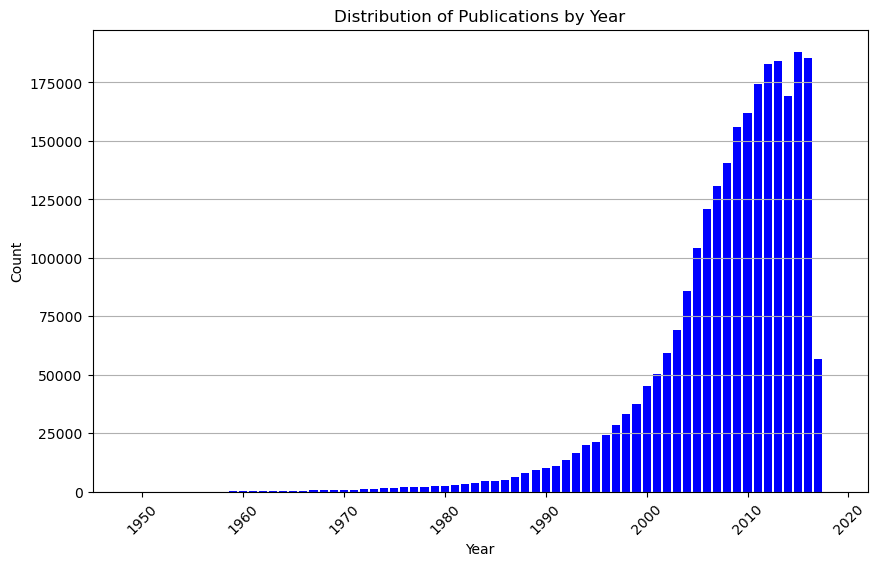

In [10]:
import matplotlib.pyplot as plt

# Distribution of 'year'
year_data = df.groupBy("year").count().orderBy("year")
year_data_pd = year_data.toPandas()
plt.figure(figsize=(10, 6))
plt.bar(year_data_pd['year'], year_data_pd['count'], color='blue')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Distribution of Publications by Year')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

Limiting the number of rows to keep spark from crashing.

In [11]:
df.rdd.getNumPartitions()

34

In [12]:
df = df.limit(200000)

4. Feature Extraction

In [13]:
features_df = df.select("id", "title", "abstract")
features_df = features_df.repartition(4, "id")
df.unpersist()
features_df.persist(StorageLevel.MEMORY_AND_DISK)

DataFrame[id: string, title: string, abstract: string]

Since other features aren't going to be used in the search engine then it makes sense to go with title+abstract and id for good measure.

## 4. Keep only the English documents

In [14]:
!pip install langdetect

In [15]:
from langdetect import detect, DetectorFactory
from pyspark.sql.functions import udf, concat_ws
DetectorFactory.seed = 0

def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"
features_df = features_df.withColumn("text", concat_ws(" ", features_df.title, features_df.abstract))
language_udf = udf(detect_language, StringType())

features_df = features_df.withColumn("language", language_udf(features_df.text))
df_english = features_df.filter(features_df.language == "en")
features_df.unpersist()
df_english.persist(StorageLevel.MEMORY_AND_DISK)
df_english.show(5)

+--------------------+--------------------+--------------------+--------------------+--------+
|                  id|               title|            abstract|                text|language|
+--------------------+--------------------+--------------------+--------------------+--------+
|028d37c8-b571-41b...|Automated Object ...|The development o...|Automated Object ...|      en|
|03990c4b-45be-491...|Multi-layer topol...|In this paper, we...|Multi-layer topol...|      en|
|03dd4db1-3540-4de...|Interval Abstract...|State-space explo...|Interval Abstract...|      en|
|04f16960-42b0-4f5...|Learning of abstr...|The acquisition o...|Learning of abstr...|      en|
|0a22ed40-c8b3-410...|PIQASso: PIsa Que...|PiQASso is a Ques...|PIQASso: PIsa Que...|      en|
+--------------------+--------------------+--------------------+--------------------+--------+
only showing top 5 rows



## 5. Preprocessing

the goal is to clean and preprocess the text to prepare it to represent it in vectors. It is a mandatory step in NLP projects to preprocess the text. You can have a look in this article to explore some of well-known preprocessing steps and find how they can be done in Spark Mlib: https://towardsdatascience.com/nlp-text-preprocessing-a-practical-guide-and-templated80874676e79, required pre-processing

In [16]:
from pyspark.ml.feature import StopWordsRemover, Tokenizer
from pyspark.sql.functions import lower, regexp_replace, col

df_english = df_english.withColumn(
    "text", 
    lower(regexp_replace("text", r'[!()\[\]{};:\'",<>./?@#$%^&*_~]', ""))
)
tokenizer = Tokenizer(inputCol="text", outputCol="words")
df_words = tokenizer.transform(df_english)
df_english.unpersist()
df_words.persist(StorageLevel.MEMORY_AND_DISK)

DataFrame[id: string, title: string, abstract: string, text: string, language: string, words: array<string>]

In [17]:
custom_stop_words = ['doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 
                     'et', 'al', 'author', 'figure', 'rights', 'reserved', 'permission', 
                     'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
                     'al.', 'Elsevier', 'PMC', 'CZI', 'www']

remover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(
    StopWordsRemover.loadDefaultStopWords("english") + custom_stop_words
)
df_filtered = remover.transform(df_words)
df_words.unpersist()
df_filtered.persist(StorageLevel.MEMORY_AND_DISK)
df_filtered.show(5)

+--------------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+
|                  id|               title|            abstract|                text|language|               words|            filtered|
+--------------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+
|028d37c8-b571-41b...|Automated Object ...|The development o...|automated object ...|      en|[automated, objec...|[automated, objec...|
|03990c4b-45be-491...|Multi-layer topol...|In this paper, we...|multi-layer topol...|      en|[multi-layer, top...|[multi-layer, top...|
|03dd4db1-3540-4de...|Interval Abstract...|State-space explo...|interval abstract...|      en|[interval, abstra...|[interval, abstra...|
|04f16960-42b0-4f5...|Learning of abstr...|The acquisition o...|learning of abstr...|      en|[learning, of, ab...|[learning, abstra...|
|0a22ed40-c8b3-410...|PIQASso: PIsa Que..

## 6. Vectorization

Convert the data into format that can be handled by ML algorithms. You can have a look on https://spark.apache.org/docs/latest/mllib-feature-extraction.html, some useful techniques are:

a. TF-IDF: this will convert string-formatted data into a measure of how important each word is to the instance out of the literature as a whole. See, https://www.youtube.com/watch?=hc3DCn8viWs for more details

b. Word2vec, https://www.youtube.com/watch?v=3eoX_waysy4


Word2Vec should be the way to go here since we have lots of data point from it to learn from (more complicated model). But since the model training times out then we'll have to go with TF-IDF.

In [18]:
from pyspark.ml.feature import  HashingTF, IDF

hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=10000)
tf = hashingTF.transform(df_filtered)
df_filtered.unpersist()
tf.persist(StorageLevel.MEMORY_AND_DISK)

DataFrame[id: string, title: string, abstract: string, text: string, language: string, words: array<string>, filtered: array<string>, rawFeatures: vector]

In [19]:
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=1)
tfidf_model = idf.fit(tf)
tfidf_df = tfidf_model.transform(tf)
tf.unpersist()
tfidf_df.persist(StorageLevel.MEMORY_AND_DISK)
tfidf_df.show(5)

+--------------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+
|                  id|               title|            abstract|                text|language|               words|            filtered|         rawFeatures|            features|
+--------------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+
|028d37c8-b571-41b...|Automated Object ...|The development o...|automated object ...|      en|[automated, objec...|[automated, objec...|(10000,[23,32,45,...|(10000,[23,32,45,...|
|03990c4b-45be-491...|Multi-layer topol...|In this paper, we...|multi-layer topol...|      en|[multi-layer, top...|[multi-layer, top...|(10000,[274,576,1...|(10000,[274,576,1...|
|03dd4db1-3540-4de...|Interval Abstract...|State-space explo...|interval abstract...|      en|[interval, 

## 7. Clustering

You can try K-means clustering. To determine K, you can run the elbow method. You can use PCA to reduce the dimensions while still keeping 95% of the variance in the data for better performance and hopefully remove some noise/outliers

Sidenote: tried running PCA, but it crashed spark somehow.

In [20]:
from pyspark.ml.clustering import KMeans

cost = []
for k in range(2, 11):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(tfidf_df)
    cost.append(model.summary.trainingCost)

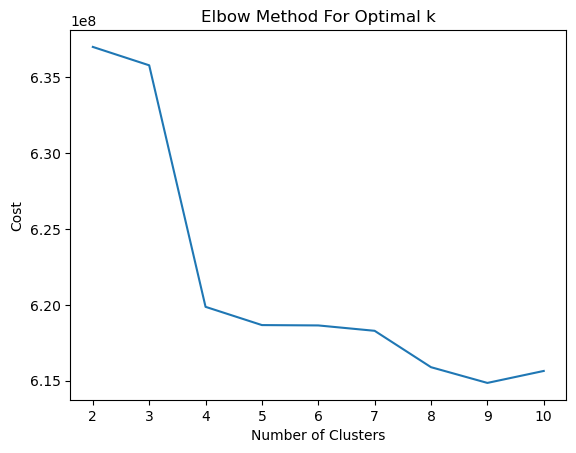

In [21]:
plt.plot(range(2, 11), cost)
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

Based on the plot we can create the model with optimal clusters.

In [22]:
optimal_k = 4
kmeans = KMeans().setK(optimal_k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(tfidf_df)
df_clustered = model.transform(tfidf_df)
df_clustered.show(5)

+--------------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+----------+
|                  id|               title|            abstract|                text|language|               words|            filtered|         rawFeatures|            features|prediction|
+--------------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+----------+
|028d37c8-b571-41b...|Automated Object ...|The development o...|automated object ...|      en|[automated, objec...|[automated, objec...|(10000,[23,32,45,...|(10000,[23,32,45,...|         0|
|03990c4b-45be-491...|Multi-layer topol...|In this paper, we...|multi-layer topol...|      en|[multi-layer, top...|[multi-layer, top...|(10000,[274,576,1...|(10000,[274,576,1...|         0|
|03dd4db1-3540-4de...|Interval Abstract...|State-s

In [23]:
tfidf_df.unpersist()
df_clustered.persist(StorageLevel.MEMORY_AND_DISK)

DataFrame[id: string, title: string, abstract: string, text: string, language: string, words: array<string>, filtered: array<string>, rawFeatures: vector, features: vector, prediction: int]

## 8. Search engine

You can implement this via a very basic recommender function that takes as input a paper title and N as the top-most N closest papers. You recommend the top-most N based on the most similar (Cosine similarity) papers to the input paper title in the cluster to which it belongs.

In [24]:
from pyspark.sql.types import StringType, StructType, StructField, DoubleType

def cosine_similarity(v1, v2):
    return v1.dot(v2) / (v1.norm(2) * v2.norm(2))

def find_similar_papers(title, top_n=5):
    query = spark.createDataFrame([(title,)], ["text"])
    query = tokenizer.transform(query)
    query = remover.transform(query)
    query = hashingTF.transform(query)
    query = tfidf_model.transform(query)
    
    query_vector = query.select("features").collect()[0][0]
    
    similarities = df_clustered.rdd.map(lambda row: (row['id'], float(cosine_similarity(row['features'], query_vector))))
    
    # Define schema for the similarities DataFrame
    schema = StructType([
        StructField("id", StringType(), True),
        StructField("similarity", DoubleType(), True)
    ])
    
    similarities_df = spark.createDataFrame(similarities, schema).orderBy(col("similarity").desc())
    
    return similarities_df.join(df_english, "id").select("title", "abstract", "similarity").sort('similarity', ascending=False).limit(top_n).toPandas()

In [25]:
find_similar_papers("A methodology for visual analytics")

,title,abstract,similarity
0,Research and Pedagogy in Business Analytics: O...,"In recent times, business analytics and big da...",0.617416
1,Visual Analytics in Environmental Research: A ...,Visual analytics approaches bring an innovativ...,0.565010
2,Designing Visual Analytic Tools for Emergency ...,The Emergency Management Information System EM...,0.538882
3,Using augmented reality to support situated an...,We draw from the domains of Visual Analytics a...,0.522242
4,"Case Study: A Visual Analytics System, Sapientia",The visual analytics is increasingly drawing a...,0.509435
